In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# for running in collab, sagemaker etc.
import sys
sys.path.insert(0, "/home/studio-lab-user/Generative_Models_for_CERN_Fast_Simulations/utils")

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import wasserstein_distance
import pickle
import time
import os
import pandas as pd
from sklearn.metrics import mean_absolute_error

import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

sns.set_theme()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Non padded version

### Load data

In [4]:
data = pd.read_pickle('../data/data_photonsum_proton_18_2312.pkl')
print('Loaded: ',  data.shape, "max:", data.max())

# Data containing particle conditional data from particle having responses with proton photon sum in interval [70, 2312] without taking into consideration photon sums of neutron responses.
data_cond = pd.read_pickle('../data/data_cond_photonsum_proton_18_2312.pkl')
print('Loaded cond: ',  data_cond.shape, "max:",data_cond.values.max(), "min:",data_cond.values.min())

In [5]:
data_cond.head()

In [4]:
NEUTRON_PROTON_PHOTON_SUM_COLS = ['neutron_photon_sum', 'proton_photon_sum']
neutron_proton_photon_sum_data = data_cond[NEUTRON_PROTON_PHOTON_SUM_COLS]

KeyError: "['neutron_photon_sum'] not in index"

In [6]:
data_cond.drop(columns=['proton_photon_sum'], inplace=True)

In [ ]:
# drop unnecessary columns
data_cond.drop(columns=['neutron_photon_sum', 'proton_photon_sum'], inplace=True)

In [7]:
CONDITIONAL_COLS = list(data_cond.columns)
CONDITIONAL_COLS

1. Flatten the proton responses dataset from shape (56, 30) to (1680, 1)

In [8]:
flatten_responses = pd.DataFrame(data.reshape(len(data), -1))
flatten_responses.shape

2. Concatenate as columns flatten dataset to each conditional row 

In [9]:
data_all = pd.concat([data_cond, flatten_responses], axis=1)
data_all.head()

3. Groupby each unique combination of conditional data and calculate standard deviation for each pixel in the grouped data

In [10]:
stddev_group = data_all.groupby(CONDITIONAL_COLS).transform(lambda x: np.std(x))
groups_numbers = data_all.groupby(CONDITIONAL_COLS).ngroup()
stddev_group.head()

In [11]:
group_sizes = data_all.groupby(CONDITIONAL_COLS).size().reset_index(name='Count')

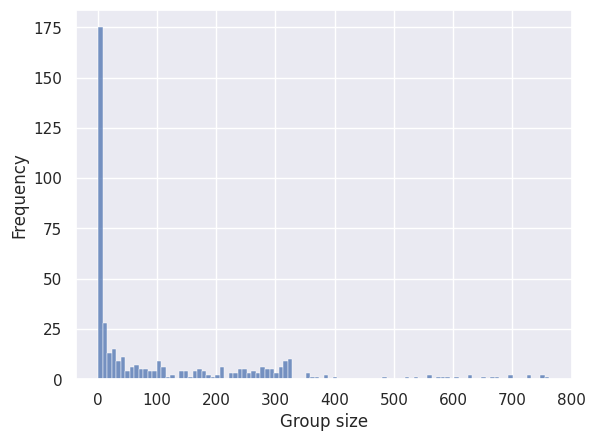

In [27]:
sns.histplot(data=group_sizes, x='Count', bins=100)
plt.xlabel('Group size')
plt.ylabel('Frequency')
plt.show()

In [12]:
groups_numbers.head(), groups_numbers.min(), groups_numbers.max()

4. Calculate sum of stddevs of pixels

In [13]:
sum_pixels = stddev_group.sum(axis=1)
sum_pixels.shape, sum_pixels.head()

In [14]:
assert data_cond.shape[0] == sum_pixels.shape[0]

5. Divide sum of stddevs by maximum value to normalize it

In [15]:
normalized_stddevs = sum_pixels/sum_pixels.max()

6. Assign calclations to each conditional data

In [16]:
data_cond['std'] = normalized_stddevs

In [17]:
data_cond.head()

#### Add informative columns 

In [62]:
data_cond[NEUTRON_PROTON_PHOTON_SUM_COLS] = neutron_proton_photon_sum_data

In [70]:
data_cond['group_number'] = groups_numbers

In [71]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge,std,neutron_photon_sum,proton_photon_sum,group_number
0,3192.38,0.000000e+00,0.000000e+00,0.000000e+00,0.022422,-0.182957,-3192.38,939.565413,0.0,0.076311,1256.0,16.0,316
1,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0,0.479201,55.0,1195.0,366
2,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0,0.090233,1122.0,23.0,280
3,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0,0.131331,230.0,78.0,317
4,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0,0.103628,655.0,34.0,165


#### Save conditional dataset

In [20]:
data_cond.to_pickle('../data/data_cond_photonsum_proton_18_2312.pkl')

## Non padded version - ALL SAMPLES PROTON

### Load data

In [3]:
DATA_DIR = "../data/"

def load_proton_a_images(n=None):
    data_a = pd.read_pickle(os.path.join(DATA_DIR, "proton_images2a.pkl"))
    data_b = pd.read_pickle(os.path.join(DATA_DIR, "proton_images2b.pkl"))
    data_c = pd.read_pickle(os.path.join(DATA_DIR, "proton_images2c.pkl"))
    return np.r_[data_a, data_b, data_c][:n]

def load_particle_data_a(n=None):
    data_a = pd.read_pickle(os.path.join(DATA_DIR, "particles_cond_with_mass2a.pkl"))
    data_b = pd.read_pickle(os.path.join(DATA_DIR, "particles_cond_with_mass2b.pkl"))
    data_c = pd.read_pickle(os.path.join(DATA_DIR, "particles_cond_with_mass2c.pkl"))
    return pd.concat([data_a, data_b, data_c], axis=0)[:n]

In [6]:
N_SAMPLES_T0_LOAD = None

data = load_proton_a_images(N_SAMPLES_T0_LOAD)
print('Loaded Proton: ',  data.shape)

data_cond = load_particle_data_a(N_SAMPLES_T0_LOAD)
print('Loaded cond: ',  data_cond.shape)

Loaded Proton:  (511810, 56, 30)
Loaded cond:  (511810, 11)


In [6]:
print('Loaded Proton: ',  data.shape)
print('Loaded cond: ',  data_cond.shape)

Loaded Proton:  (344228, 56, 30)
Loaded cond:  (344228, 10)


In [7]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge,std_proton
0,1304.340,-0.000018,0.000016,0.050293,-0.509192,0.461106,1304.340,0.000000,0.0,0.057045
1,325.158,0.000000,0.000000,0.000000,0.269915,-0.081921,325.157,139.570610,-1.0,0.017925
2,3192.380,0.000000,0.000000,0.000000,0.022422,-0.182957,-3192.380,939.565413,0.0,0.071715
3,2082.630,0.000000,0.000000,0.000000,-0.171176,0.281748,2082.630,938.272081,1.0,0.157685
4,174.401,0.000005,0.000002,-0.002588,0.292035,0.104749,-174.400,0.000000,0.0,0.038993


In [6]:
# data_cond.rename(columns={'PhotonSum': 'neutron_photon_sum'}, inplace=True)
# data_cond.neutron_photon_sum = data_cond.neutron_photon_sum.astype(float)
data_cond['proton_photon_sum'] = np.sum(data, axis=(1,2))
# data_cond.drop(columns=['Pdg'], inplace=True)

True

In [7]:
PROTON_PHOTON_SUM_COLS = ['proton_photon_sum']
neutron_proton_photon_sum_data = data_cond[PROTON_PHOTON_SUM_COLS]

In [9]:
# drop unnecessary columns
data_cond.drop(columns=['proton_photon_sum'], inplace=True)

In [10]:
CONDITIONAL_COLS = list(data_cond.columns)
CONDITIONAL_COLS

['Energy', 'Vx', 'Vy', 'Vz', 'Px', 'Py', 'Pz', 'mass', 'charge']

1. Flatten the proton responses dataset from shape (56, 30) to (1680, 1)

In [11]:
flatten_responses = pd.DataFrame(data.reshape(len(data), -1))
flatten_responses.shape, data_cond.shape

((186097, 1680), (186097, 9))

2. Concatenate as columns flatten dataset to each conditional row

In [12]:
data_all = pd.concat([data_cond, flatten_responses], axis=1)
data_all.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge,0,...,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679
0,1304.340,-0.000018,0.000016,0.050293,-0.509192,0.461106,1304.340,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,325.158,0.000000,0.000000,0.000000,0.269915,-0.081921,325.157,139.570610,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3192.380,0.000000,0.000000,0.000000,0.022422,-0.182957,-3192.380,939.565413,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2082.630,0.000000,0.000000,0.000000,-0.171176,0.281748,2082.630,938.272081,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,174.401,0.000005,0.000002,-0.002588,0.292035,0.104749,-174.400,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
data_all.shape

(186097, 1689)

3. Groupby each unique combination of conditional data and calculate standard deviation for each pixel in the grouped data

In [14]:
stddev_group = data_all.groupby(CONDITIONAL_COLS).transform(lambda x: np.std(x))
groups_numbers = data_all.groupby(CONDITIONAL_COLS).ngroup()
stddev_group.head()

,0,1,2,3,4,5,6,7,8,9,...,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679
0,0.160535,0.154378,0.176905,0.086064,0.074604,0.060971,0.128920,0.136386,0.105538,0.043153,...,0.000000,0.043153,0.000000,0.0,0.000000,0.000000,0.043153,0.043153,0.000000,0.086306
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.203931,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.246595,0.209753,0.239875,0.213576,0.232409,0.239041,0.229779,0.283730,0.246103,0.277594,...,0.036515,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.036515
3,0.101268,0.175096,0.247406,0.175096,0.160203,0.101268,0.101268,0.143590,0.000000,0.101268,...,0.101268,0.000000,0.101268,0.0,0.160203,0.071795,0.303805,0.160203,0.276414,0.287179
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036179,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
group_sizes = data_all.groupby(CONDITIONAL_COLS).size().reset_index(name='Count')

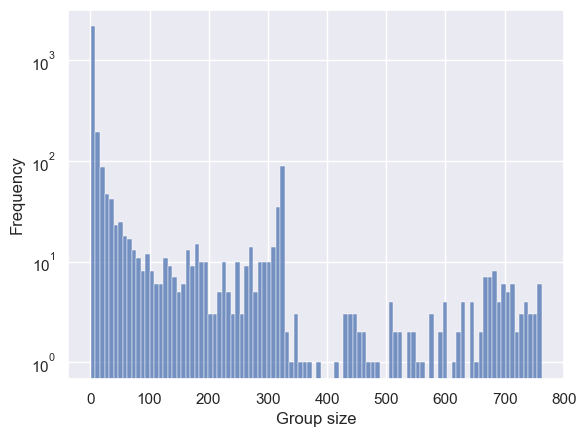

In [16]:
sns.histplot(data=group_sizes, x='Count', bins=100)
plt.xlabel('Group size')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

In [16]:
groups_numbers.head(), groups_numbers.min(), groups_numbers.max()

(0    5879
 1    4268
 2    6374
 3    6191
 4    3030
 dtype: int64,
 0,
 6504)

4. Calculate sum of stddevs of pixels

In [17]:
sum_pixels = stddev_group.sum(axis=1)
sum_pixels.shape, sum_pixels.head()

((186097,),
 0    118.213370
 1     40.681246
 2    138.392162
 3    371.042141
 4     74.736157
 dtype: float64)

In [18]:
sum_pixels.shape[0]

186097

In [19]:
assert data_cond.shape[0] == sum_pixels.shape[0]

5. Divide sum of stddevs by maximum value to normalize it

In [20]:
normalized_stddevs = sum_pixels/sum_pixels.max()

In [21]:
normalized_stddevs

0         0.060663
1         0.020876
2         0.071018
3         0.190404
4         0.038352
            ...   
186092    0.023191
186093    0.427253
186094    0.263543
186095    0.026345
186096    0.482894
Length: 186097, dtype: float64

In [22]:
normalized_stddevs.min(), normalized_stddevs.max()

(0.0, 1.0)

6. Assign calclations to each conditional data

In [23]:
data_cond['std_proton'] = normalized_stddevs

In [24]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge,std_proton
0,1304.340,-0.000018,0.000016,0.050293,-0.509192,0.461106,1304.340,0.000000,0.0,0.060663
1,325.158,0.000000,0.000000,0.000000,0.269915,-0.081921,325.157,139.570610,-1.0,0.020876
2,3192.380,0.000000,0.000000,0.000000,0.022422,-0.182957,-3192.380,939.565413,0.0,0.071018
3,2082.630,0.000000,0.000000,0.000000,-0.171176,0.281748,2082.630,938.272081,1.0,0.190404
4,174.401,0.000005,0.000002,-0.002588,0.292035,0.104749,-174.400,0.000000,0.0,0.038352


In [18]:
data_cond['proton_photon_sum'] = np.sum(data, axis=(1,2))

#### Add informative columns

In [25]:
data_cond['group_number_proton'] = groups_numbers

In [19]:
data_cond.head()

## Version for 2 datasets

Basically the same opperation but the calcuation of std are done separately for each dataset (proton, neutron).

In [6]:
data_proton = pd.read_pickle('../data/data_proton_photonsum_n_15_2133_p_15_3273.pkl')
print('Loaded: ',  data_proton.shape, "max:", data_proton.max())

Loaded:  (48714, 56, 30) max: 678.0


In [7]:
data_neutron = pd.read_pickle('../data/data_neutron_photonsum_n_15_2133_p_15_3273.pkl')
print('Loaded: ',  data_neutron.shape, "max:", data_neutron.max())

Loaded:  (48714, 44, 44) max: 532.0


In [9]:
data_cond = pd.read_pickle('../data/data_cond_photonsum_p_15_2133_n_15_3273.pkl')
print('Loaded cond: ',  data_cond.shape, "max:", data_cond.values.max(), "min:", data_cond.values.min())

Loaded cond:  (48714, 12) max: 7000.0 min: -7000.0


In [10]:
NEUTRON_PROTON_PHOTON_SUM_COLS = ['neutron_photon_sum', 'proton_photon_sum']
neutron_proton_photon_sum_data = data_cond[NEUTRON_PROTON_PHOTON_SUM_COLS]

In [11]:
# drop unnecessary columns
data_cond.drop(columns=['Pdg', 'neutron_photon_sum', 'proton_photon_sum'], inplace=True)

In [12]:
CONDITIONAL_COLS = list(data_cond.columns)
CONDITIONAL_COLS

['Energy', 'Vx', 'Vy', 'Vz', 'Px', 'Py', 'Pz', 'mass', 'charge']

1. Flatten the proton responses dataset from shape (56, 30) and (44, 44) to (1680, 1), (1936, 1) and respectively

In [13]:
flatten_responses_p = pd.DataFrame(data_proton.reshape(len(data_proton), -1))
flatten_responses_n = pd.DataFrame(data_neutron.reshape(len(data_neutron), -1))
flatten_responses_p.shape, flatten_responses_n.shape

((48714, 1680), (48714, 1936))

2. Concatenate as columns flatten dataset to each conditional row 

In [14]:
data_all_p = pd.concat([data_cond, flatten_responses_p], axis=1)
data_all_n = pd.concat([data_cond, flatten_responses_n], axis=1)
data_all_p.head(), data_all_n.head()

(    Energy            Vx            Vy            Vz        Px        Py  \
 0  3192.38  0.000000e+00  0.000000e+00  0.000000e+00  0.022422 -0.182957   
 1  3961.55  0.000000e+00  0.000000e+00  0.000000e+00 -0.076487  0.179845   
 2  2770.10  1.861170e-17  2.517190e-17 -1.689330e-13  0.305187  0.412760   
 3  3195.12  0.000000e+00  0.000000e+00  0.000000e+00  0.560528 -0.149980   
 4  1714.07  0.000000e+00  0.000000e+00  0.000000e+00  0.457768  0.145639   
 
         Pz        mass  charge    0  ...  1670  1671  1672  1673  1674  1675  \
 0 -3192.38  939.565413     0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
 1  3961.55  938.272081     1.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
 2 -2770.10  497.611000     0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
 3  3195.11  938.272081     1.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
 4 -1714.07  939.565413     0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
 
    1676  1677  1678  1679  
 0   0.0   0.0   0.

3. Groupby each unique combination of conditional data and calculate standard deviation for each pixel in the grouped data

In [15]:
stddev_group_p = data_all_p.groupby(CONDITIONAL_COLS).transform(lambda x: np.std(x))
groups_numbers_p = data_all_p.groupby(CONDITIONAL_COLS).ngroup()

stddev_group_n = data_all_n.groupby(CONDITIONAL_COLS).transform(lambda x: np.std(x))
groups_numbers_n = data_all_n.groupby(CONDITIONAL_COLS).ngroup()

In [16]:
stddev_group_p.head()

,0,1,2,3,4,5,6,7,8,9,...,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679
0,0.254516,0.244383,0.307023,0.246475,0.268779,0.273279,0.265414,0.319725,0.319725,0.327021,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0.426174,0.512069,0.571778,0.532310,0.590742,0.667918,0.799832,0.989204,0.930898,1.169566,...,0.036564,0.051674,0.00000,0.089462,0.051674,0.0,0.0,0.0,0.051674,0.000000
2,0.262211,0.260189,0.274860,0.294282,0.274860,0.270964,0.387579,0.627706,1.180524,1.185916,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.052058,0.052058
3,0.722909,0.679524,0.705660,0.679306,0.705898,0.807521,0.802229,0.842848,0.910366,0.894244,...,0.000000,0.000000,0.03649,0.036490,0.072981,0.0,0.0,0.0,0.000000,0.036490
4,0.480302,0.427709,0.493697,0.545372,0.491977,0.502993,0.542508,0.511905,0.542273,0.503802,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.036202,0.036202


In [17]:
stddev_group_n.head()

,0,1,2,3,4,5,6,7,8,9,...,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935
0,0.173754,0.181215,0.302812,0.237893,0.245496,0.295705,0.303975,0.237893,0.264141,0.262739,...,0.165910,0.202822,0.182186,0.165910,0.190203,0.196225,0.226947,0.241110,0.105844,0.182186
1,0.063245,0.000000,0.036564,0.036564,0.036564,0.036564,0.072980,0.036564,0.051674,0.036564,...,0.350685,0.400189,0.401088,0.376459,0.385477,0.320755,0.367464,0.345169,0.362045,0.371326
2,0.089921,0.073520,0.073520,0.115769,0.155225,0.089921,0.103689,0.126643,0.137248,0.052058,...,1.256634,1.170183,1.057449,1.741674,0.931772,0.547269,0.602158,0.574129,0.687489,0.561856
3,0.063119,0.051571,0.063119,0.072835,0.072835,0.089084,0.072835,0.063119,0.089084,0.063119,...,1.778751,1.550043,1.449402,1.390140,1.316872,1.317561,1.097848,1.003593,0.982988,0.899273
4,0.080738,0.036202,0.036202,0.095621,0.051164,0.108290,0.072262,0.108290,0.095621,0.102160,...,0.816477,0.705540,0.573821,0.550708,0.545351,0.516742,0.450932,0.419200,0.374538,0.340573


In [18]:
group_sizes_p = data_all_p.groupby(CONDITIONAL_COLS).size().reset_index(name='Count')

In [19]:
group_sizes_n = data_all_n.groupby(CONDITIONAL_COLS).size().reset_index(name='Count')

In [20]:
groups_numbers_p.head(), groups_numbers_p.min(), groups_numbers_p.max()

(0    316
 1    366
 2    280
 3    317
 4    165
 dtype: int64,
 0,
 435)

In [21]:
groups_numbers_n.head(), groups_numbers_n.min(), groups_numbers_n.max()

(0    316
 1    366
 2    280
 3    317
 4    165
 dtype: int64,
 0,
 435)

4. Calculate sum of stddevs of pixels

In [22]:
sum_pixels_p = stddev_group_p.sum(axis=1)
sum_pixels_p.shape, sum_pixels_p.head()

((48714,),
 0    154.329429
 1    969.117461
 2    182.483892
 3    265.598939
 4    209.572895
 dtype: float64)

In [23]:
sum_pixels_n = stddev_group_n.sum(axis=1)
sum_pixels_n.shape, sum_pixels_n.head()

((48714,),
 0    1282.758022
 1     258.796416
 2    1581.252346
 3     526.648564
 4     722.137794
 dtype: float64)

In [24]:
assert data_cond.shape[0] == sum_pixels_p.shape[0]
assert data_cond.shape[0] == sum_pixels_n.shape[0]

5. Divide sum of stddevs by maximum value to normalize it

In [25]:
normalized_stddevs_p = sum_pixels_p/sum_pixels_p.max()
normalized_stddevs_n = sum_pixels_n/sum_pixels_n.max()

6. Assign calclations to each conditional data

In [26]:
data_cond['std_proton'] = normalized_stddevs_p
data_cond['std_neutron'] = normalized_stddevs_n

#### Add informative columns 

In [27]:
data_cond[NEUTRON_PROTON_PHOTON_SUM_COLS] = neutron_proton_photon_sum_data

In [28]:
data_cond['group_number_proton'] = groups_numbers_p
data_cond['group_number_neutron'] = groups_numbers_n

In [29]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge,std_proton,std_neutron,neutron_photon_sum,proton_photon_sum,group_number_proton,group_number_neutron
0,3192.38,0.000000e+00,0.000000e+00,0.000000e+00,0.022422,-0.182957,-3192.38,939.565413,0.0,0.076311,0.632134,1256.0,16.0,316,316
1,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0,0.479201,0.127533,55.0,1195.0,366,366
2,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0,0.090233,0.779230,1122.0,23.0,280,280
3,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0,0.131331,0.259529,230.0,78.0,317,317
4,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0,0.103628,0.355864,655.0,34.0,165,165


#### Save conditional dataset

In [30]:
data_cond.to_pickle('../data/data_cond_stddev_photonsum_p_15_2133_n_15_3273.pkl')

## Padded version

Basically the same opperation but the calcuation of std are done separately for each channel (proton, neutron).
First channel has PROTON DATA, second has NEUTRON data.

In [4]:
data = pd.read_pickle('../data/data_proton_neutron_photonsum_proton_18_1970_neutron_18_3249_padding.pkl')
print('Loaded: ',  data.shape, "max:", data.max())

# Data containing particle conditional data from particle having responses with proton photon sum in interval [70, 2312] without taking into consideration photon sums of neutron responses.
data_cond = pd.read_pickle('../data/data_cond_photonsum_18.pkl')
print('Loaded cond: ',  data_cond.shape, "max:",data_cond.values.max(), "min:",data_cond.values.min())

Loaded:  (38348, 56, 44, 2) max: 603.0
Loaded cond:  (38348, 11) max: 7000.0 min: -7000.0


In [5]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,neutron_photon_sum,mass,charge,proton_photon_sum
0,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,55.0,938.272081,1.0,1195.0
1,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,1122.0,497.611000,0.0,23.0
2,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,230.0,938.272081,1.0,78.0
3,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,655.0,939.565413,0.0,34.0
4,1948.29,1.323670e-08,5.575600e-09,-5.280860e-05,0.470391,0.154206,-1948.29,1142.0,0.000000,0.0,19.0


In [6]:
first_channel = data[:, :, :, 0]
second_channel = data[:, :, :, 1]
first_channel.shape, second_channel.shape

((38348, 56, 44), (38348, 56, 44))

In [7]:
NEUTRON_PROTON_PHOTON_SUM_COLS = ['neutron_photon_sum', 'proton_photon_sum']
neutron_proton_photon_sum_data = data_cond[NEUTRON_PROTON_PHOTON_SUM_COLS]

In [9]:
# drop unnecessary columns
data_cond.drop(columns=['neutron_photon_sum', 'proton_photon_sum'], inplace=True)

In [10]:
CONDITIONAL_COLS = list(data_cond.columns)
CONDITIONAL_COLS

['Energy', 'Vx', 'Vy', 'Vz', 'Px', 'Py', 'Pz', 'mass', 'charge']

1. Flatten the proton responses dataset from shape (56, 30) to (1680, 1)

In [11]:
flatten_responses_1 = pd.DataFrame(first_channel.reshape(len(first_channel), -1))
flatten_responses_2 = pd.DataFrame(second_channel.reshape(len(second_channel), -1))
flatten_responses_1.shape, flatten_responses_2.shape

((38348, 2464), (38348, 2464))

2. Concatenate as columns flatten dataset to each conditional row 

In [12]:
data_all_1 = pd.concat([data_cond, flatten_responses_1], axis=1)
data_all_2 = pd.concat([data_cond, flatten_responses_2], axis=1)
data_all_1.head(), data_all_2.head()

(    Energy            Vx            Vy            Vz        Px        Py  \
 0  3961.55  0.000000e+00  0.000000e+00  0.000000e+00 -0.076487  0.179845   
 1  2770.10  1.861170e-17  2.517190e-17 -1.689330e-13  0.305187  0.412760   
 2  3195.12  0.000000e+00  0.000000e+00  0.000000e+00  0.560528 -0.149980   
 3  1714.07  0.000000e+00  0.000000e+00  0.000000e+00  0.457768  0.145639   
 4  1948.29  1.323670e-08  5.575600e-09 -5.280860e-05  0.470391  0.154206   
 
         Pz        mass  charge    0  ...  2454  2455  2456  2457  2458  2459  \
 0  3961.55  938.272081     1.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
 1 -2770.10  497.611000     0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
 2  3195.11  938.272081     1.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
 3 -1714.07  939.565413     0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
 4 -1948.29    0.000000     0.0  0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
 
    2460  2461  2462  2463  
 0   0.0   0.0   0.

3. Groupby each unique combination of conditional data and calculate standard deviation for each pixel in the grouped data

In [13]:
stddev_group_1 = data_all_1.groupby(CONDITIONAL_COLS).transform(lambda x: np.std(x))
groups_numbers_1 = data_all_1.groupby(CONDITIONAL_COLS).ngroup()

stddev_group_2 = data_all_2.groupby(CONDITIONAL_COLS).transform(lambda x: np.std(x))
groups_numbers_2 = data_all_2.groupby(CONDITIONAL_COLS).ngroup()

In [14]:
stddev_group_1.head()

,0,1,2,3,4,5,6,7,8,9,...,2454,2455,2456,2457,2458,2459,2460,2461,2462,2463
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.426466,0.514252,0.570065,...,0.0,0.052022,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.259172,0.286207,0.298012,...,0.0,0.058621,0.058621,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.722909,0.679524,0.705660,...,0.0,0.000000,0.036490,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.480302,0.427709,0.493697,...,0.0,0.036202,0.036202,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.439716,0.394589,0.424638,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
stddev_group_2.head()

,0,1,2,3,4,5,6,7,8,9,...,2454,2455,2456,2457,2458,2459,2460,2461,2462,2463
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
group_sizes_1 = data_all_1.groupby(CONDITIONAL_COLS).size().reset_index(name='Count')

In [17]:
group_sizes_2 = data_all_2.groupby(CONDITIONAL_COLS).size().reset_index(name='Count')

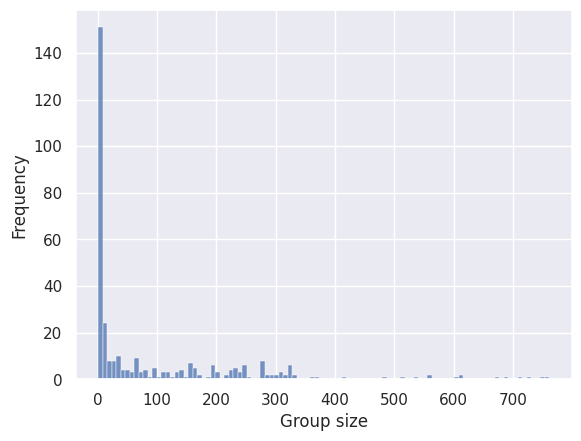

In [19]:
sns.histplot(data=group_sizes_1, x='Count', bins=100)
plt.xlabel('Group size')
plt.ylabel('Frequency')
plt.show()

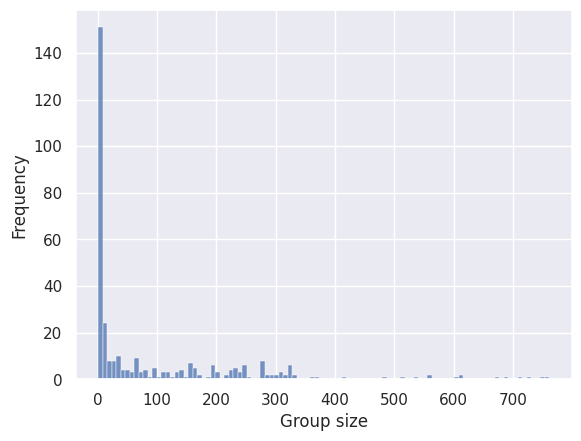

In [20]:
sns.histplot(data=group_sizes_2, x='Count', bins=100)
plt.xlabel('Group size')
plt.ylabel('Frequency')
plt.show()

The same plots as expected

In [18]:
groups_numbers_1.head(), groups_numbers_1.min(), groups_numbers_1.max()

(0    309
 1    231
 2    260
 3    128
 4    150
 dtype: int64,
 0,
 372)

In [19]:
groups_numbers_2.head(), groups_numbers_2.min(), groups_numbers_2.max()

(0    309
 1    231
 2    260
 3    128
 4    150
 dtype: int64,
 0,
 372)

4. Calculate sum of stddevs of pixels

In [20]:
sum_pixels_1 = stddev_group_1.sum(axis=1)
sum_pixels_1.shape, sum_pixels_1.head()

((38348,),
 0    958.892469
 1    190.440197
 2    265.598939
 3    209.572895
 4    143.882056
 dtype: float64)

In [21]:
sum_pixels_2 = stddev_group_2.sum(axis=1)
sum_pixels_2.shape, sum_pixels_2.head()

((38348,),
 0     259.685031
 1    1446.833653
 2     526.648564
 3     722.137794
 4     604.991258
 dtype: float64)

In [22]:
assert data_cond.shape[0] == sum_pixels_1.shape[0]
assert data_cond.shape[0] == sum_pixels_2.shape[0]

5. Divide sum of stddevs by maximum value to normalize it

In [23]:
normalized_stddevs_1 = sum_pixels_1/sum_pixels_1.max()
normalized_stddevs_2 = sum_pixels_2/sum_pixels_2.max()

6. Assign calclations to each conditional data

In [24]:
data_cond['std_proton'] = normalized_stddevs_1
data_cond['std_neutron'] = normalized_stddevs_2

#### Add informative columns 

In [25]:
data_cond[NEUTRON_PROTON_PHOTON_SUM_COLS] = neutron_proton_photon_sum_data

In [29]:
data_cond['group_number_proton'] = groups_numbers_1
data_cond['group_number_neutron'] = groups_numbers_2

In [26]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge,std_proton,std_neutron,neutron_photon_sum,proton_photon_sum
0,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0,0.477555,0.128712,55.0,1195.0
1,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0,0.094844,0.717121,1122.0,23.0
2,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0,0.132276,0.261033,230.0,78.0
3,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0,0.104373,0.357926,655.0,34.0
4,1948.29,1.323670e-08,5.575600e-09,-5.280860e-05,0.470391,0.154206,-1948.29,0.000000,0.0,0.071657,0.299863,1142.0,19.0


#### Save conditional dataset

In [27]:
data_cond.head()

,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge,std_proton,std_neutron,neutron_photon_sum,proton_photon_sum
0,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0,0.477555,0.128712,55.0,1195.0
1,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0,0.094844,0.717121,1122.0,23.0
2,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0,0.132276,0.261033,230.0,78.0
3,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0,0.104373,0.357926,655.0,34.0
4,1948.29,1.323670e-08,5.575600e-09,-5.280860e-05,0.470391,0.154206,-1948.29,0.000000,0.0,0.071657,0.299863,1142.0,19.0


In [29]:
data_cond.to_pickle('../data/data_cond_stddev_photonsum_p_18_n_18.pkl')

In [76]:
data_cond['proton_photon_sum'] = np.sum(data, axis=(1,2))